In [1]:
import pandas as pd
import numpy as np
import re
import random
from pygsp import *
from networkx import is_tree
import networkx as nx
import sympy as sy
from sympy.solvers import solve
from sympy import Symbol

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(palette = 'deep')
plotting.BACKEND = 'matplotlib'
# plt.rcParams['font.family'] = 'sans-serif'
colormap = plt.cm.get_cmap('Spectral') 
colormap = colormap.reversed()
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

### Import temperature and latitude datasets


In [2]:
Temp = pd.read_csv('..\Graph Signal Processing\Temperature.csv')
Lat = pd.read_csv('..\Graph Signal Processing\Latitude.csv')
Temp.shape, Lat.shape

((48, 2), (48, 5))

In [25]:
# collect data in a single dataframe
df = Lat.copy()
df['Temperature'] = Temp['Avg F']
df['weight'] = df['Latitude']/(np.sqrt(df['Latitude']**2+df['Longitude']**2)).values
# save the file
df.to_csv('..\Graph Signal Processing\data.csv')

# -------for descibing the positon of nodes-----
pos_array=df[['Longitude','Latitude']].values
pos_dict = {}
for key,(i,j) in enumerate(pos_array):
    pos_dict[key] =  [i,j]
# ---------------------------------------------
df[:5]

,State,Abbr,Bordering States,Latitude,Longitude,Temperature,weight
0,Alabama,AL,"Florida, Georgia, Mississippi, Tennessee",32.806671,-86.791130,62.8,0.353579
1,Arizona,AZ,"California, Colorado, Nevada, New Mexico, Utah",33.729759,-111.431221,60.3,0.289714
2,Arkansas,AR,"Louisiana, Mississippi, Missouri, Oklahoma, Te...",34.969704,-92.373123,60.4,0.354049
3,California,CA,"Arizona, Nevada, Oregon",36.116203,-119.681564,59.4,0.288901
4,Colorado,CO,"Arizona, Kansas, Nebraska, New Mexico, Oklahom...",39.059811,-105.311104,45.1,0.347750


In [4]:
df[df['State'] == 'Alabama']['weight'].values[0]

0.3535789213932027

In [5]:
# This weight works
# df[df.index==i]['Latitude']/(np.sqrt(df[df.index==i]['Latitude']**2+df[df.index==i]['Longitude']**2))


# A directed edge between states is assigned based on latitudes; from lower to higher.
# The corresponding adjacency matrces are 
directed_adj = np.zeros((df.shape[0],df.shape[0]))
undirected_adj = np.zeros((df.shape[0],df.shape[0]))
symm_adj = np.zeros((df.shape[0],df.shape[0]))

# Weighted Versions
directed_adj_w = np.zeros((df.shape[0],df.shape[0]))
symm_adj_w = np.zeros((df.shape[0],df.shape[0]))

for i, row in df.iterrows():
    latitute = row['Latitude']
#     print(row['Bordering States'])
    for state in row['Bordering States'].split(','):
        if state[0]==' ':
            state = state[1:]
#         print(state)
#         print(df[df['State'] == state]['Latitude'].values[0])
        j=df[df['State'] == state].index[0]
        undirected_adj[i][j] = 1
        directed_adj_w[i][j] = df[df['State'] == state]['weight'].values[0]
        if latitute <= df[df['State'] == state]['Latitude'].values[0]:
            directed_adj[i][j] = 1
        
# defining the symmetrized adj
for i in range(symm_adj.shape[0]):
    for j in range(symm_adj.shape[1]):
        symm_adj[i][j] = 0.5*(directed_adj[i][j]+directed_adj[j][i])
        symm_adj_w[i][j] = 0.5*(directed_adj_w[i][j]+directed_adj_w[j][i])
        
# define the degree matrix
D = np.diag(np.sum(undirected_adj,-1)**(-0.5))

# define the weighted degree matrix
D_w = np.diag(np.sum(symm_adj,-1)**(-0.5))

# define the weighted_symm degree matrix
D_symm = np.diag(np.sum(symm_adj_w,-1)**(-0.5))


directed_adj[:5,:5]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [6]:
np.sum(directed_adj, -1)
# 16,31,42,44 - no edge points from them to other states 

array([2., 5., 3., 2., 3., 3., 2., 2., 3., 3., 3., 3., 3., 2., 6., 2., 0.,
       2., 2., 2., 1., 3., 4., 1., 3., 3., 2., 2., 3., 2., 2., 0., 2., 3.,
       1., 1., 2., 1., 3., 3., 4., 2., 0., 2., 0., 3., 1., 3.])

In [7]:
df[df.index == 31]

,State,Abbr,Bordering States,Latitude,Longitude,Temperature,weight
31,North Dakota,ND,"Minnesota, Montana, South Dakota",47.528912,-99.784012,40.4,0.430027


#### Undirected Case

In [8]:
# create the graph using the Adjacency matrices
G_gsp_dir = graphs.Graph(directed_adj)
G_gsp_undir = graphs.Graph(undirected_adj)

G_gsp_undir.compute_laplacian('normalized')
G_gsp_undir.compute_fourier_basis(recompute=True) 
# G_gsp_undir.U
G_gsp_undir.L.todense()[:5,:5]

matrix([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  1.        ,  0.        , -0.25819889, -0.16903085],
        [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
        [ 0.        , -0.25819889,  0.        ,  1.        ,  0.        ],
        [ 0.        , -0.16903085,  0.        ,  0.        ,  1.        ]])

#### Unweighted Undirected Symmetrized Case

In [9]:
# calculate fourier basis
Unweighted_lapl_symm = np.identity(df.shape[0]) - D_w@symm_adj@D_w
# Weighted_lapl = np.identity(df.shape[0]) - D_symm@directed_adj_w@D_symm

eigenValues_w,U_w = np.linalg.eigh(Unweighted_lapl_symm)
# eigenValues_w

#### Weighted Undirected Symmetrized Case

In [10]:
# calculate fourier basis
Weighted_lapl_symm = np.identity(df.shape[0]) - D_symm@symm_adj_w@D_symm
# Weighted_lapl = np.identity(df.shape[0]) - D_symm@directed_adj_w@D_symm

#  For Sorting
# eigenValues_w,U_w = np.linalg.eig(Weighted_lapl_symm)
# idx = eigenValues_w.argsort() #do [::-1] for descending order
# eigenValues_w = eigenValues_w[idx]
# U_w = U_w[:,idx]

eigenValues_symm,U_symm = np.linalg.eigh(Weighted_lapl_symm)
# eigenValues_symm

#### Gain Case

In [11]:
q_gain = 0.0

# defining the gain adjacency matrix
def hadamard_adj(q):
    adj = np.zeros((df.shape[0],df.shape[0]),dtype=complex)
    for i in range(df.shape[0]):
        for j in range(df.shape[0]):
#             adj[i][j] = np.exp(2*(np.pi)*q*1j*(directed_adj[i][j]-directed_adj[j][i]))
            adj[i][j] = np.exp(2*(np.pi)*q*1j*(directed_adj_w[i][j]-directed_adj_w[j][i]))
    return adj

gain_lapl = np.identity(df.shape[0]) - D@np.multiply(hadamard_adj(q_gain),undirected_adj)@D

# calculate fourier basis
eigenValues_gain,U_gain = np.linalg.eigh(gain_lapl)

# gain_lapl[:5,:5]

#### Hermitian Case

In [12]:
q_hermitian = 0.0

# unweighted_symm
# hermitian_lapl = np.identity(df.shape[0]) - D_w@np.multiply(hadamard_adj(q_hermitian),symm_adj)@D_w

# weighted_symm
hermitian_lapl = np.identity(df.shape[0]) - D_symm@np.multiply(hadamard_adj(q_hermitian),symm_adj_w)@D_symm

# calculate fourier basis
eigenValues_hermitian,U_hermitian = np.linalg.eigh(hermitian_lapl)

# hermitian_lapl[:5,:5]

### Calculating Errors for denoised signals

In [13]:
# adding noise to the signal
exp_undir= np.zeros(df.shape[0],dtype='complex')
exp_hermitian = np.zeros(df.shape[0],dtype='complex')
exp_gain = np.zeros(df.shape[0],dtype='complex')

# Temperature signals on different graphs
denoised_signal_undir = np.zeros(df.shape[0])
denoised_signal_gain = np.zeros(df.shape[0])
denoised_signal_hermitian = np.zeros(df.shape[0])

# noised signal
noised_temp=np.zeros(df.shape[0])

# number of simulations
sim = 1000

# define the low pass filter kernel
c=0.4
def filter(eigen):
    return 1/(1+c*eigen)

np.random.seed(0)

# permoing sim number of simulations
for i in range(sim):
    noise = np.random.normal(loc = 0,scale=10,size=df.shape[0])
    noised_temp  = noise+df['Temperature'].values

#  -----------------------------------------------------------------
     # denoised signal for undirected case
#     H = np.diag(filter(G_gsp_undir.e))
#     denoised_signal_undir = G_gsp_undir.U@H@G_gsp_undir.U.T@noised_temp
#     # Error for undirected case
#     exp_undir += (1/sim)*denoised_signal_undir

# exp_undir = G_gsp_undir.U@H@G_gsp_undir.U.T@df['Temperature'].values
    
    
    # denoised signal for symm_unweighted case
#     H = np.diag(filter(eigenValues_w))
#     denoised_signal_undir = U_w@H@U_w.T@noised_temp
#     # Error for undirected case
#     exp_undir += (1/sim)*denoised_signal_undir
    
# exp_undir = U_w@H@U_w.T@df['Temperature'].values
    

    
    # denoised signal for symm_weighted case
    H = np.diag(filter(eigenValues_symm))
    denoised_signal_undir = U_symm@H@U_symm.T@noised_temp
    # Error for undirected case
    exp_undir += (1/sim)*denoised_signal_undir
    
# exp_undir = U_symm@H@U_symm.T@df['Temperature'].values

#  -----------------------------------------------------------------
    # denoised signal for hermitian case
    H = np.diag(filter(eigenValues_hermitian))
    denoised_signal_hermitian = U_hermitian@H@(np.conjugate(U_hermitian).T)@noised_temp
    # Error for hermitian case
    exp_hermitian += (1/sim)*denoised_signal_hermitian
    
    
# exp_hermitian = U_hermitian@H@(np.conjugate(U_hermitian).T)@df['Temperature'].values

#  -----------------------------------------------------------------
    # denoised signal for Gain case
    H = np.diag(filter(eigenValues_gain))
    denoised_signal_gain = U_gain@H@np.conjugate(U_gain).T@noised_temp
    # Error for Gain case
    exp_gain += (1/sim)*denoised_signal_gain
    
# exp_gain = U_gain@H@np.conjugate(U_gain).T@df['Temperature'].values

#  -----------------------------------------------------------------
    
e_undir,e_hermitian,e_gain = np.linalg.norm(exp_undir-df['Temperature'].values),\
                             np.linalg.norm(exp_hermitian-df['Temperature'].values),\
                             np.linalg.norm(exp_gain-df['Temperature'].values)
#  -----------------------------------------------------------------

In [14]:
e_undir,e_gain,e_hermitian

(20.174513894251316, 19.7897860819567, 20.17451389425131)

### Create the barplots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


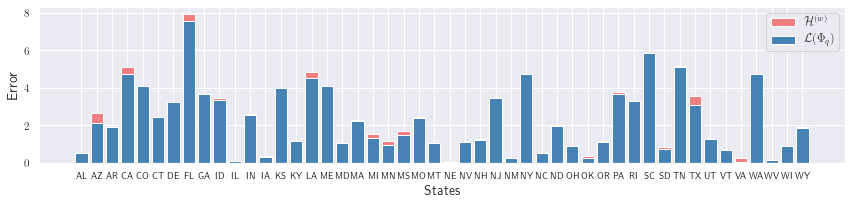

In [17]:
plt.figure(figsize =(12, 3)) 
sns.set(palette='deep')
xticks = [i for i in range(df.shape[0])]
plt.bar(xticks, np.absolute(exp_hermitian-df['Temperature'].values),color='lightcoral', alpha=1)
plt.bar(xticks, np.absolute(exp_gain-df['Temperature'].values),color='steelblue', alpha=1)
# plt.bar(xticks, np.absolute(exp_undir-df['Temperature'].values),color='yellowgreen', alpha=0.2)
plt.xticks(xticks,labels=df['Abbr'].to_list(),fontsize=9)
plt.axis('tight')
plt.ylabel("Error",fontsize=14)
plt.xlabel("States",fontsize=14)
# plt.legend(['Hermitian','Gain'])
plt.legend([r'$\mathcal{H}^{(w)}$',r'$\mathcal{L}(\Phi_q)$'],fontsize=12)
plt.tight_layout()
#  -----------------------------------------------------------------
# plt.savefig('..\Graph Signal Processing\Images\Error_Barplot.eps',format='eps',dps=200)
plt.savefig('..\Graph Signal Processing\Images\Error_Barplot_Hermitian_weighted.eps',format='eps',dps=200)
# plt.savefig('..\Graph Signal Processing\Images\Error_Barplot_weighted_symm.eps',format='eps',dps=200)
#  -----------------------------------------------------------------
plt.show()

### Relation b/w Gain error and value of q

#### Gain Case

In [ ]:
q_list = np.linspace(0,1,100)

# defining the gain adjacency matrix
def gain_eigv(q):
    adj = np.zeros((df.shape[0],df.shape[0]),dtype=complex)
    for i in range(df.shape[0]):
        for j in range(df.shape[0]):
#             adj[i][j] = np.exp(2*(np.pi)*q*1j*(directed_adj[i][j]-directed_adj[j][i]))
            adj[i][j] = np.exp(2*(np.pi)*q*1j*(directed_adj_w[i][j]-directed_adj_w[j][i]))
    
    gain_lapl = np.identity(df.shape[0]) - D@np.multiply(adj,undirected_adj)@D
    return np.linalg.eigh(gain_lapl)

# defining the hermitian matrix
def herm_eigv(q):
    adj = np.zeros((df.shape[0],df.shape[0]),dtype=complex)
    for i in range(df.shape[0]):
        for j in range(df.shape[0]):
#             adj[i][j] = np.exp(2*(np.pi)*q*1j*(directed_adj[i][j]-directed_adj[j][i]))
            adj[i][j] = np.exp(2*(np.pi)*q*1j*(directed_adj_w[i][j]-directed_adj_w[j][i]))
    
#     hermitian_lapl = np.identity(df.shape[0]) - D_w@np.multiply(adj,symm_adj)@D_w
    hermitian_lapl = np.identity(df.shape[0]) - D_symm@np.multiply(adj,symm_adj_w)@D_symm
    return np.linalg.eigh(hermitian_lapl)

### Calculating Errors for denoised signals

In [ ]:
e_gain_list = []
denoised_signal_gain = np.zeros(df.shape[0])

e_hermitian_list = []
denoised_signal_hermitian = np.zeros(df.shape[0])

# number of simulations
sim = 100

# define the low pass filter kernel
c=0.4
def filter(eigen):
    return 1/(1+c*eigen)



# permoing sim number of simulations
for q in q_list:
    exp_gain = np.zeros(df.shape[0],dtype='complex')
    exp_hermitian= np.zeros(df.shape[0],dtype='complex')
    np.random.seed(0)
    for i in range(sim):
        noise = np.random.normal(loc = 0,scale=10,size=df.shape[0])
        noised_temp  = noise+df['Temperature'].values
        
#  -----------------------------------------------------------------
        # denoised signal for hermitian case
        eigenValues_hermitian,U_hermitian = herm_eigv(q)
        H = np.diag(filter(eigenValues_hermitian))
        denoised_signal_hermitian = U_hermitian@H@(np.conjugate(U_hermitian).T)@noised_temp
        # Error for hermitian case
        exp_hermitian += (1/sim)*denoised_signal_hermitian
    
#     exp_hermitian = U_hermitian@H@(np.conjugate(U_hermitian).T)@df['Temperature'].values
#  -----------------------------------------------------------------
        # denoised signal for Gain case
        eigenValues_gain,U_gain = gain_eigv(q)
        H = np.diag(filter(eigenValues_gain))
        denoised_signal_gain = U_gain@H@np.conjugate(U_gain).T@noised_temp
#         # Error for Gain case
        exp_gain += (1/sim)*denoised_signal_gain
        
#     exp_gain=U_gain@H@np.conjugate(U_gain).T@df['Temperature'].values
# -----------------------------------------------------------------
    e_gain_list.append(np.linalg.norm(exp_gain-df['Temperature'].values))
    e_hermitian_list.append(np.linalg.norm(exp_hermitian-df['Temperature'].values))
e_gain_list[:5]

In [ ]:
q_list[np.argmin(e_gain_list)], e_gain_list[np.argmin(e_gain_list)]

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(q_list, e_hermitian_list,color='lightcoral')
plt.plot(q_list, e_gain_list,color='steelblue')
plt.title('Unweighted',fontsize=14)
plt.ylabel('Error',fontsize=14)
plt.xlabel('q',fontsize=14)
# plt.legend(['Gain','Hermitian'])
plt.legend([r'$\mathcal{H}$',r'$\mathcal{L}(\Phi_q)$'],fontsize=12)
plt.tight_layout()
plt.savefig('..\Graph Signal Processing\Images\WU_GainError_vs_q.eps',format='eps',dpi=200)
plt.show()

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(q_list, e_gain_list,color='steelblue')
plt.plot(q_list, e_hermitian_list,color='lightcoral')
plt.title('Weighted',fontsize=14)
plt.ylabel('Error',fontsize=14)
plt.xlabel('q',fontsize=14)
# plt.legend(['Gain','Hermitian'])
plt.legend([r'$\mathcal{H}$',r'$\mathcal{L}(\Phi_q)$'],fontsize=12)
plt.tight_layout()
plt.savefig('..\Graph Signal Processing\Images\Weighted_GainError_vs_q.eps',format='eps',dpi=200)
plt.show()

## Comparison With [Shafipour et al](https://arxiv.org/pdf/1804.03000.pdf)

In [25]:
# np.save('..\Graph Signal Processing\Ieee_U.npy',U_comp)
# U_comp = np.load('..\Graph Signal Processing\Ieee_U.npy')
import scipy 
U_comp = scipy.io.loadmat('U.mat')['U']

# spectral window
w=3

# filter
H_ieee = np.diag([1 if i<= w-1 else 0 for i in range(df.shape[0])])
# U_comp = algorithm2(epsilon)

denoised_signal_ieee = U_comp@H_ieee@U_comp.T@noised_temp
error_ieee = np.linalg.norm(denoised_signal_ieee-df['Temperature'].values)
error_ieee

350.93366694165695

### Comparing Errors

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


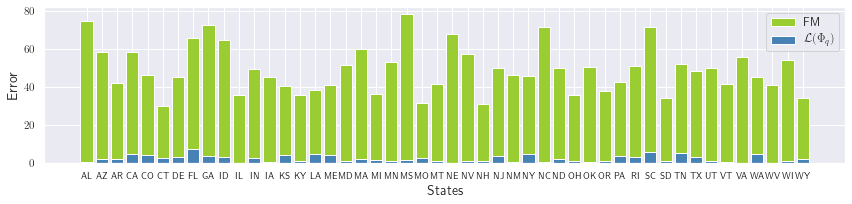

In [26]:
plt.figure(figsize =(12, 3)) 

# plt.bar(xticks, e_undir)
xticks = [i for i in range(df.shape[0])]
plt.bar(xticks, np.absolute(denoised_signal_ieee-df['Temperature'].values),color='yellowgreen', alpha=1)
plt.bar(xticks, np.absolute(exp_gain-df['Temperature'].values),color='steelblue', alpha=1)
plt.xticks(xticks,labels=df['Abbr'].to_list(),fontsize=9)
plt.axis('tight')
plt.ylabel("Error",fontsize=14)
plt.xlabel("States",fontsize=14)
# plt.legend(['FM','Gain'])
plt.legend(['FM',r'$\mathcal{L}(\Phi_q)$'],fontsize=12)
plt.tight_layout()
#  -----------------------------------------------------------------
plt.savefig('..\Graph Signal Processing\Images\Error_Barplot_IEEE.eps',format='eps',dps=200)
#  -----------------------------------------------------------------
plt.show()

### Plotting spectral window and error

In [27]:
# spectral window
w_list=list(range(1,df.shape[0]+1))
error_ieee_list = []

for w in w_list:
    # filter
    H_ieee = np.diag([1 if i<= w-1 else 0 for i in range(df.shape[0])])
    # U_comp = algorithm2(epsilon)

    denoised_signal_ieee = U_comp@H_ieee@U_comp.T@noised_temp
    error_ieee = np.linalg.norm(denoised_signal_ieee-df['Temperature'].values)
    error_ieee_list.append(error_ieee)

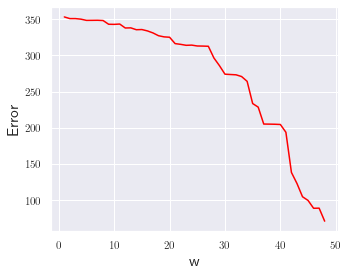

In [30]:
plt.figure(figsize=(5,4))
plt.plot(w_list, error_ieee_list,color='red')
# plt.plot(w_list, [358 for i in range(df.shape[0])],color='steelblue')
# plt.title('Weighted')
plt.ylabel('Error',fontsize=16)
plt.xlabel('w',fontsize=16)
# plt.legend(['Feasible Method','Gain'])
plt.tight_layout()
plt.savefig('..\Graph Signal Processing\Images\Ieee_w.eps',format='eps',dpi=200)
plt.show()

# Solving Eq. for q using Sympy

#### Gain Case

In [ ]:
# define the kernel parameter
c=0.4
pi,e = np.pi,np.exp(1)

# uncomment to get an expression in terms of q
# q = Symbol('q', real=True)

# to check for a particuar value of q
q=0

# original signal 
f = sy.Matrix(df['Temperature'].values)

* Unweighted

In [ ]:
# defining the gain adjacency matrix
hadamard_adj = sy.zeros(df.shape[0],df.shape[0],dtype=complex)
for i in range(df.shape[0]):
    for j in range(df.shape[0]):
            hadamard_adj[i,j] = e**(2*pi*q*1j*(directed_adj[i][j]-directed_adj[j][i]))
    
c=0.4
# converting into sympy dtype
D_sy = sy.Matrix(D)
gain_lapl = sy.eye(df.shape[0]) - D_sy *(sy.Matrix(undirected_adj).multiply_elementwise(hadamard_adj))*D_sy 

# calculating inverse
inverse = (sy.eye(df.shape[0])+c*gain_lapl).inv(method='LU')
inverse_sqr = inverse*inverse-inverse

# unweighted
gain_lapl_diff = gain_lapl.multiply_elementwise(sy.Matrix(directed_adj)-sy.Matrix(directed_adj).T)


expression = (inverse_sqr*gain_lapl_diff*inverse)+(inverse*gain_lapl_diff*inverse_sqr)
expression_final = sy.simplify(f.T*expression*f)
expression_final

* Weighted

In [ ]:
# defining the gain adjacency matrix
hadamard_adj = sy.zeros(df.shape[0],df.shape[0],dtype=complex)
for i in range(df.shape[0]):
    for j in range(df.shape[0]):
        hadamard_adj[i,j] = e**(2*pi*q*1j*(directed_adj_w[i][j]-directed_adj_w[j][i]))
    
# converting into sympy dtype
D = sy.Matrix(D)
gain_lapl = sy.eye(df.shape[0]) - D*(sy.Matrix(undirected_adj).multiply_elementwise(hadamard_adj))*D

# calculating inverse
inverse = (sy.eye(df.shape[0])+c*gain_lapl).inv(method='LU')
inverse_sqr = inverse*inverse-inverse

# Weighted
gain_lapl_diff = gain_lapl.multiply_elementwise(sy.Matrix(directed_adj_w)-sy.Matrix(directed_adj_w).T)

expression = (inverse_sqr*gain_lapl_diff*inverse)+(inverse*gain_lapl_diff*inverse_sqr)
expression_final = sy.simplify(f.T*expression*f)
expression_final

### Numerical Example (as given in our paper)

In [ ]:
# f = sy.Matrix([1,2,3])
# def filter(eigen):
#     return 1/(1+c*eigen)
# H = np.diag(filter(np.array([0,1,2])))
# H_final = H**3-H**2
# U_q = sy.Matrix([[np.sqrt(2)*(e**(2*pi*1j*q)),0, -np.sqrt(2)*(e**(2*pi*1j*q))]
#                 ,[1,1,1],[1,-1,1]])

l = sy.Matrix([[1,-(e**(2*pi*1j*q))/np.sqrt(2), -(e**(2*pi*1j*q))/np.sqrt(2)],
                   [(-e**(-2*pi*1j*q))/np.sqrt(2),1,0],[(-e**(-2*pi*1j*q))/np.sqrt(2),0,1]])

l_diff = sy.Matrix([[0,-(e**(2*pi*1j*q))/np.sqrt(2), -(e**(2*pi*1j*q))/np.sqrt(2)],
                   [(e**(-2*pi*1j*q))/np.sqrt(2),0,0],[(e**(-2*pi*1j*q))/np.sqrt(2),0,0]])

inverse = (sy.eye(3)+c*l).inv()
inverse_sqr = inverse*inverse-inverse

expression = (inverse_sqr*l_diff*inverse)+(inverse*l_diff*inverse_sqr)
expression_final = sy.simplify(f.T*expression*f)

In [ ]:
expression

In [ ]:
expression_final

### Drawing directed graph using NetworkX

In [ ]:
# G_nx = nx.to_networkx_graph(directed_adj, create_using=nx.DiGraph)
# plt.figure(figsize =(8, 5)) 
# plt.tight_layout()

# # ------------
# pos_array=df[['Longitude','Latitude']].values
# pos_dict = {}
# for key,(i,j) in enumerate(pos_array):
#     pos_dict[key] =  [i,j]
# # ------------

# nx.draw_networkx(G_nx,pos=pos_dict, labels=df['Abbr'].to_dict(),with_label = True, node_color = range(48)) 
# plt.savefig('..\Graph Signal Processing\Images\Temp_directed_graph.png',format='png',dpi=200)

#### Creating the Undirected  and Directed Graphs

48 nodes, 110 edges
True


Text(0.5, 1.0, '')

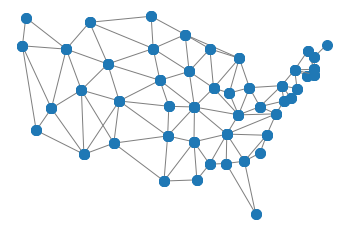

In [15]:
# create the graph using the Adjacency matrices
G_gsp_dir = graphs.Graph(directed_adj)
G_gsp_undir = graphs.Graph(undirected_adj)
print('{} nodes, {} edges'.format(G_gsp_dir.N, G_gsp_dir.Ne))
print(G_gsp_dir.is_directed())
G_gsp_dir.set_coordinates(kind=pos_array,labels=df['Abbr'].to_dict(),with_label = True)
G_gsp_undir.set_coordinates(kind=pos_array,labels=df['Abbr'].to_dict(),with_label = True)
G_gsp_dir.plot()
plt.axis('off')
plt.title('')

### Drawing Directed graph using NetworkX

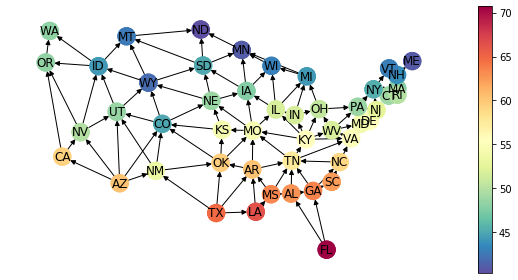

In [17]:
G_nx = nx.to_networkx_graph(directed_adj, create_using=nx.DiGraph)
plt.figure(figsize =(8, 4)) 


nc = nx.draw_networkx_nodes(G_nx, pos=pos_dict, label=df['Abbr'].to_dict(), with_label = True, 
                            node_color=df['Temperature'].values,cmap=colormap)
nx.draw_networkx(G_nx,pos=pos_dict, labels=df['Abbr'].to_dict(),with_label = True, 
                 node_color=df['Temperature'].values,cmap=colormap) 

plt.colorbar(nc)
plt.tight_layout()
plt.box(False)
plt.savefig('..\Graph Signal Processing\Images\Temp_directed_graph.eps',format='eps',dpi=200)

### Drawing Undirected graph using NetworkX

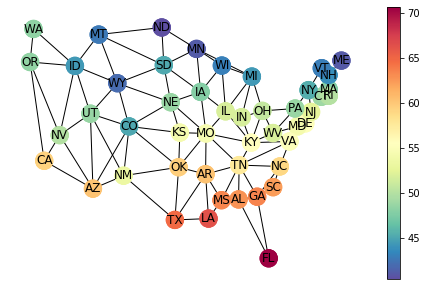

In [19]:
G_nx = nx.to_networkx_graph(undirected_adj)
plt.figure(figsize =(8, 5)) 
plt.tight_layout()

nc = nx.draw_networkx_nodes(G_nx, pos=pos_dict, label=df['Abbr'].to_dict(), with_label = True, 
                            node_color=df['Temperature'].values,cmap=colormap)
nx.draw_networkx(G_nx,pos=pos_dict, labels=df['Abbr'].to_dict(),with_label = True, 
                 node_color=df['Temperature'].values,cmap=colormap) 

plt.colorbar(nc)
plt.box(False)
# plt.savefig('..\Graph Signal Processing\Images\Temp_directed_graph.png',format='png',dpi=200)

### Subplots using NetworkX

In [21]:
def scale(X):
    min_,max_ = min(df['Temperature'].values), max(df['Temperature'].values)
    X_std = (X - min(X)) / (max(X) - min(X))
    X_scaled = X_std * (max_ - min_) + min_
    return X_scaled
# scale(denoised_signal_hermitian)

In [24]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set(palette='deep')

numbering = [['(a) ','(b) ','(c) '],['(d) ','(e) ','(f) ']]
labels = [['original','noised','denoised (undir)'],['denoised (hermitian)','denoised (gain)',
           'denoised (FM)']]
# graph_type = ['G_gsp_undir','G_gsp_dir','G_gsp_dir']
signals = [[df['Temperature'].values,noised_temp,denoised_signal_undir],
           [denoised_signal_hermitian,denoised_signal_gain,denoised_signal_ieee]]
# denoised_signals = ['denoised_signal_undir','denoised_signal_gain','denoised_signal_hermitian']
f,axes = plt.subplots(2,3,figsize = (13,7))
row,col = 0,0
while row < 2:
    plt.figure(figsize=(7, 4))
    if labels[row][col] in ['denoised (hermitian)','denoised (FM)']:
        if labels[row][col] == 'denoised (FM)':
            denoised_signal = scale(signals[row][col])
        else:
            denoised_signal = signals[row][col]
            
#         print(max(denoised_signal))
        G_nx = nx.to_networkx_graph(directed_adj, create_using=nx.DiGraph)
        nc = nx.draw_networkx_nodes(G_nx, pos=pos_dict,node_color=denoised_signal,cmap=colormap,
                                    ax = axes[row,col],node_size=100)
        nx.draw_networkx(G_nx,pos=pos_dict, node_color=denoised_signal,cmap=colormap,ax = axes[row,col],
                        with_labels=False) 

        divider = make_axes_locatable(axes[row,col])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        f.colorbar(nc, cax=cax, orientation='vertical')
        axes[row,col].set_yticklabels('')
        axes[row,col].set_xticklabels('')
        axes[row,col].set_xlabel(numbering[row][col]+labels[row][col])
        axes[row,col].set(frame_on=False)
    #         axes[row,col].set_title('')
        col+=1
    else:
        G_nx = nx.to_networkx_graph(undirected_adj)
        nc = nx.draw_networkx_nodes(G_nx, pos=pos_dict,node_color=scale(signals[row][col]),cmap=colormap,
                                    ax = axes[row,col],node_size=100)
        nx.draw_networkx(G_nx,pos=pos_dict, node_color=scale(signals[row][col]),cmap=colormap,ax = axes[row,col],
                         with_labels=False) 

        divider = make_axes_locatable(axes[row,col])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        f.colorbar(nc, cax=cax, orientation='vertical')
        axes[row,col].set_yticklabels('')
        axes[row,col].set_xticklabels('')
        axes[row,col].set_xlabel(numbering[row][col]+labels[row][col])
        axes[row,col].set(frame_on=False)
#         axes[row,col].set_title('')
        col+=1
        
    if col==3:
        row+=1
        col=0

f.tight_layout()
# f.savefig('..\Graph Signal Processing\Images\graph_subplots_new.eps',format='eps',dpi=200)
plt.clf()
plt.show()